In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Change the working directory to one level higher
if not os.getcwd().endswith('tqs_unitaries'):
    os.chdir('..')

In [3]:
import numpy as np

file_path = 'out/default/tqs_vs_exact_isingy_n12_param1.0000.npz'
data = np.load(file_path)

print(data.files)

psi_tqs = data["psi_tqs"]
psi_exact = data["psi_exact"]

['psi_tqs', 'psi_exact', 'overlap']


In [4]:
np.linalg.norm(psi_tqs)

np.float32(0.1195759)

In [5]:
import matplotlib.pyplot as plt

def normalize_and_plot(complex_wf: np.ndarray, title: str):
    # Normalize psi_tqs
    psi_normalized = complex_wf / np.linalg.norm(psi_tqs)

    # Plot real and imaginary components
    plt.figure(figsize=(12, 6))
    plt.plot(psi_normalized.real, label='Real Part')
    plt.plot(psi_normalized.imag, label='Imaginary Part')
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()


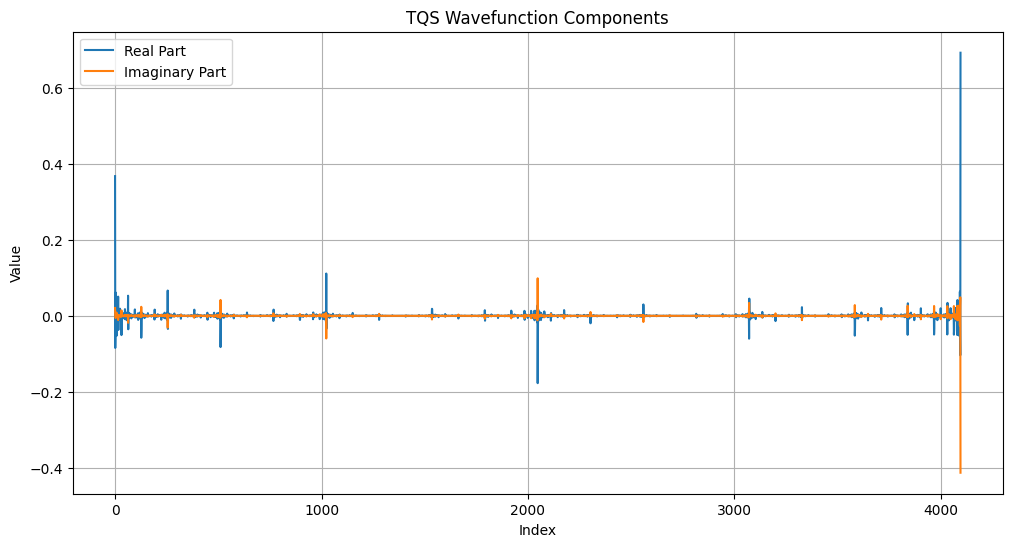

In [6]:
normalize_and_plot(psi_tqs, title='TQS Wavefunction Components')

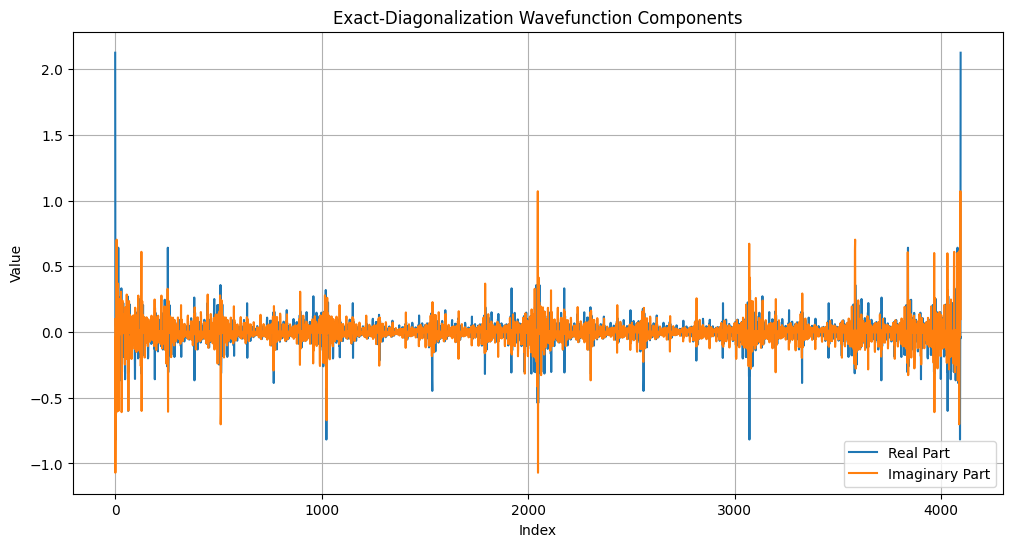

In [7]:
normalize_and_plot(psi_exact, title='Exact-Diagonalization Wavefunction Components')

In [8]:
import torch
from model import TransformerModel
from Hamiltonian_utils import dec2bin
from model_utils import compute_psi

In [9]:
system_sizes = np.arange(10, 41, 2).reshape(-1, 1)
param_dim = 1
embedding_size = 32
n_head = 8
n_hid = embedding_size
n_layers = 8
dropout = 0
minibatch = 10000
system_size = 12

eval_system_size = torch.tensor([system_size], dtype=torch.int64, device="cpu")
eval_param = torch.tensor([1.0])

model = TransformerModel(
    system_sizes,
    param_dim,
    embedding_size,
    n_head,
    n_hid,
    n_layers,
    dropout=dropout,
    minibatch=minibatch,
)

/home/spandan/Projects/tqs_unitaries/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [10]:
n = eval_system_size.prod().item()
model.set_param(eval_system_size, eval_param)

all_dec = torch.arange(2**n, dtype=torch.int64)
all_configs = dec2bin(all_dec, n).T  # (n, 2^n)

In [11]:
state_dict = torch.load("results-plain/ckpt_2100_Ising_32_8_8_0.ckpt")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [12]:
all_configs[:, 0], all_configs[:, -1]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [13]:
with torch.no_grad():
    log_amp, log_phase = compute_psi(model, all_configs, check_duplicate=False)

In [14]:
log_phase

tensor([ 38.1337,  44.4498,  44.4511,  ..., 106.9325, 106.9613, 113.3547])

In [15]:
def reproduce_psi(log_amp: torch.Tensor, log_phase: torch.Tensor) -> torch.Tensor:
    """
    Produces full imaginary wave function pointwise as a function of log_amps
    and log_phases, as output by the TQS model.
    """

    return log_amp.exp() * torch.exp(1j * log_phase)

In [16]:
psi_tqs_reproduced = reproduce_psi(log_amp, log_phase).cpu().numpy()

In [17]:
log_amp.exp().sum()

tensor(1.0000)

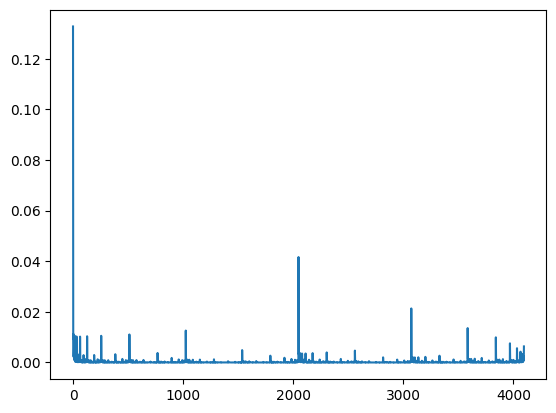

In [18]:
plt.plot(log_amp.exp())

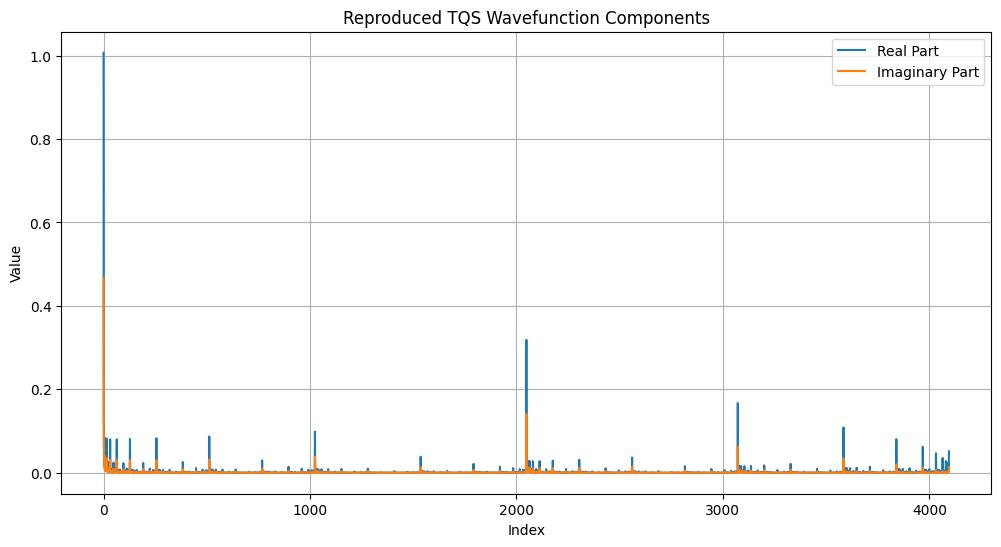

In [19]:
normalize_and_plot(psi_tqs_reproduced, title='Reproduced TQS Wavefunction Components')

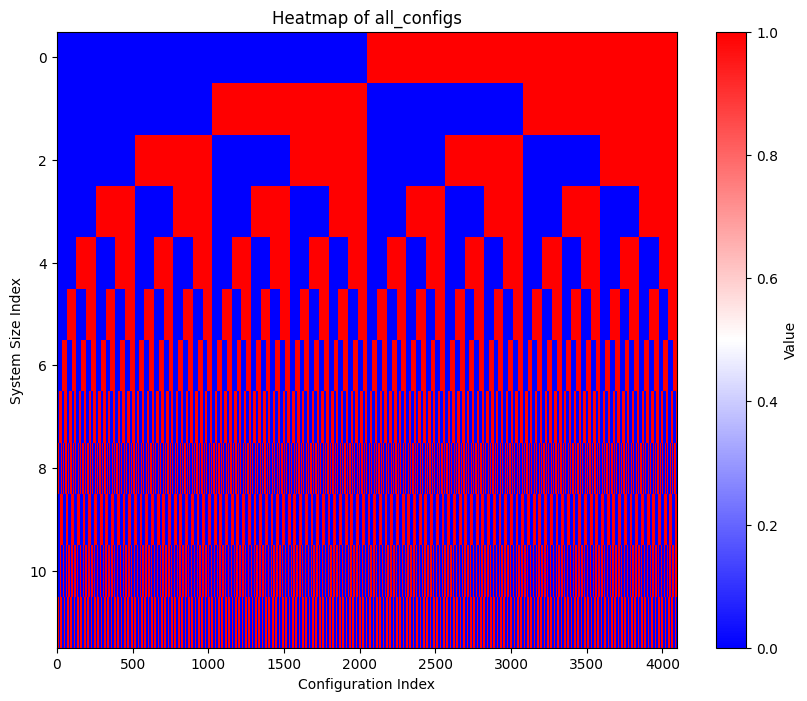

In [20]:
plt.figure(figsize=(10, 8))
plt.imshow(all_configs.numpy(), aspect='auto', cmap='bwr', interpolation='none')
plt.colorbar(label='Value')
plt.title('Heatmap of all_configs')
plt.xlabel('Configuration Index')
plt.ylabel('System Size Index')
plt.show()